In [35]:
# --- Libraries ---
import pandas as pd
import numpy as np
import torch
import random
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Set Seed ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# --- Data Preparation ---
def prepare_data(device, path, n_samples=400, test_size=0.2, recal_size=0.2, batch_size=32, seed=5):
    set_seed(seed)
    data = pd.read_excel(path).sample(n=n_samples, random_state=seed)

    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2:].values

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train, X_recal, y_train, y_recal = train_test_split(X_temp, y_temp, test_size=recal_size / (1 - test_size), random_state=seed)

    # Tensors
    X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
    X_recal, y_recal = torch.tensor(X_recal).float(), torch.tensor(y_recal).float()
    X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

    mean_X, std_X = X_train.mean(0), X_train.std(0)
    mean_y, std_y = y_train.mean(0), y_train.std(0)

    X_train = (X_train - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X
    X_recal = (X_recal - mean_X) / std_X

    y_train = (y_train - mean_y) / std_y
    y_test = (y_test - mean_y) / std_y
    y_recal = (y_recal - mean_y) / std_y

    return (
        X_train.to(device), y_train.to(device), 
        DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True),
        X_test.to(device), y_test.to(device),
        mean_X, std_X, mean_y, std_y
    )

# --- Model ---
class MultiOutputMCDropout(nn.Module):
    def __init__(self, input_size, n_hidden=32, dropout_p=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(input_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc_mean = nn.Linear(n_hidden, 2)
        self.fc_cov = nn.Linear(n_hidden, 3)

    def forward(self, x):
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        mean = self.fc_mean(self.dropout(x))
        cov_params = self.fc_cov(self.dropout(x))
        log_var = cov_params[:, :2]
        rho = 0.99 * torch.tanh(cov_params[:, 2])
        std = torch.exp(0.5 * log_var)
        cov12 = rho * std[:, 0] * std[:, 1]
        cov = torch.zeros(x.size(0), 2, 2, device=x.device)
        cov[:, 0, 0] = std[:, 0]**2
        cov[:, 1, 1] = std[:, 1]**2
        cov[:, 0, 1] = cov12
        cov[:, 1, 0] = cov12
        return mean, cov

# --- Loss ---
def multi_output_nll(mean, cov, y):
    eps = 1e-3
    eye = torch.eye(2, device=mean.device).unsqueeze(0)
    dist = torch.distributions.MultivariateNormal(mean, cov + eps * eye)
    return -dist.log_prob(y).mean()

# --- Train ---
def train(model, optimizer, train_loader, device, epochs=500):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            mean, cov = model(xb)
            loss = multi_output_nll(mean, cov, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}, Loss: {total_loss:.3f}")

# --- MC Prediction ---
def mc_predict(model, X, n_samples=300):
    model.train()
    means, covs = [], []
    with torch.no_grad():
        for _ in range(n_samples):
            m, c = model(X)
            means.append(m.cpu().numpy())
            covs.append(c.cpu().numpy())
    return np.stack(means), np.stack(covs)

# --- Predictive Stats ---
def compute_tau(p=0.9, l=1.0, N=400, wd=1e-5):
    return (p * l**2) / (2 * N * wd)

def predictive_stats_with_tau(mc_means, mc_covs, tau):
    mean = mc_means.mean(axis=0)
    epi_cov = np.einsum('tni,tnj->nij', mc_means, mc_means) / mc_means.shape[0] - np.einsum('ni,nj->nij', mean, mean)
    ale_cov = mc_covs.mean(axis=0)
    total_cov = ale_cov + epi_cov + np.eye(2) * (1 / tau)
    return mean, np.array([np.diag(c) for c in total_cov]), total_cov

def compute_picp(y_true, pred_mean, total_var, confidence=0.8):
    z = norm.ppf((1 + confidence) / 2)
    lower = pred_mean - z * np.sqrt(total_var)
    upper = pred_mean + z * np.sqrt(total_var)
    picp = np.mean((y_true >= lower) & (y_true <= upper), axis=0) * 100
    return lower, upper, picp

# --- Run Everything ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "synthetic_data.xlsx"
X_train, y_train, train_loader, X_test, y_test, mean_X, std_X, mean_y, std_y = prepare_data(device, path)

model = MultiOutputMCDropout(input_size=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, train_loader, device)

mc_means, mc_covs = mc_predict(model, X_test)
tau = compute_tau(N=len(X_train))
pred_mean, total_diag, total_cov = predictive_stats_with_tau(mc_means, mc_covs, tau)
y_test_np = y_test.cpu().numpy()
_, _, picp = compute_picp(y_test_np, pred_mean, total_diag)

print(f"PICP@80% Measured: {picp[0]:.2f}%, Predicted: {picp[1]:.2f}%")


Epoch 1, Loss: 21.931
Epoch 101, Loss: 6.797
Epoch 201, Loss: 5.947
Epoch 301, Loss: 5.060
Epoch 401, Loss: 3.805
Epoch 500, Loss: 3.599
PICP@80% Measured: 98.75%, Predicted: 78.75%


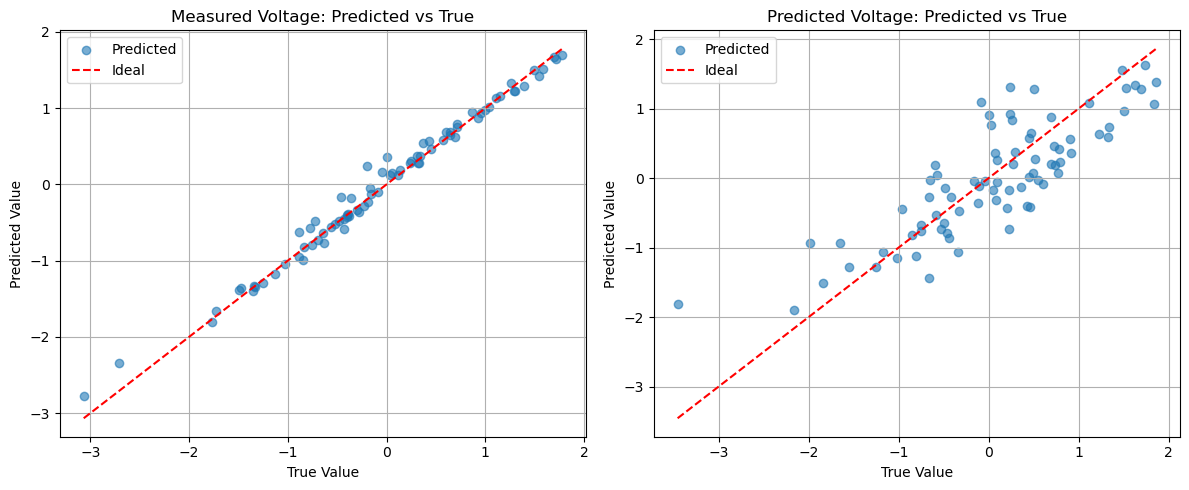

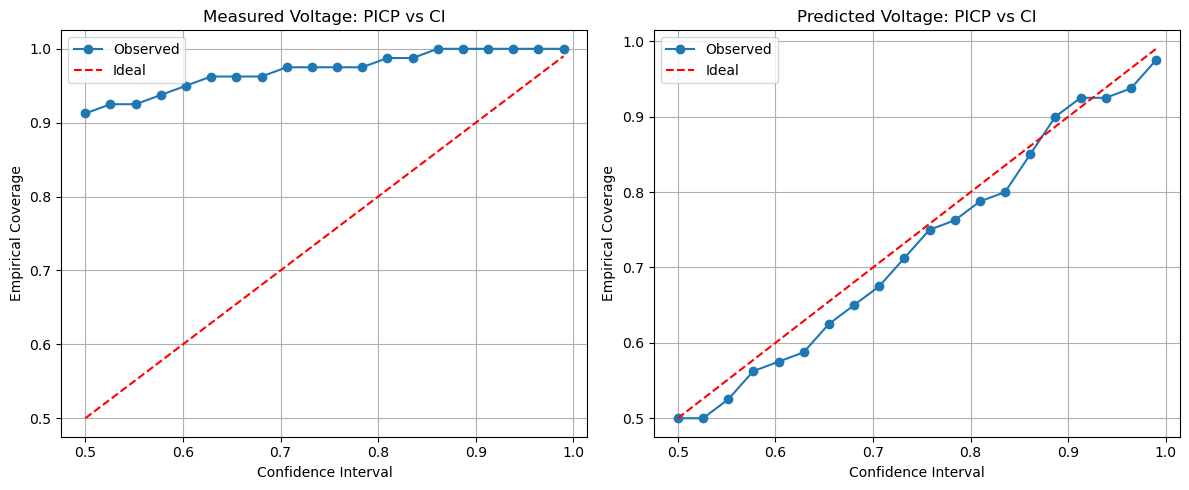

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot 1: Predicted vs True for both targets
def plot_predictions_vs_true(y_true, pred_mean, target_names=["Measured Voltage", "Predicted Voltage"]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(2):
        axs[i].scatter(y_true[:, i], pred_mean[:, i], alpha=0.6, label='Predicted')
        axs[i].plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()],
                    'r--', label='Ideal')
        axs[i].set_title(f"{target_names[i]}: Predicted vs True")
        axs[i].set_xlabel("True Value")
        axs[i].set_ylabel("Predicted Value")
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

# Plot 2: PICP curve
def plot_picp_curve(y_true, pred_mean, total_var, target_names=["Measured Voltage", "Predicted Voltage"], levels=np.linspace(0.5, 0.99, 20)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(2):
        empirical_coverage = []
        z_values = norm.ppf((1 + levels) / 2)
        for z in z_values:
            lower = pred_mean[:, i] - z * np.sqrt(total_var[:, i])
            upper = pred_mean[:, i] + z * np.sqrt(total_var[:, i])
            coverage = np.mean((y_true[:, i] >= lower) & (y_true[:, i] <= upper))
            empirical_coverage.append(coverage)
        axs[i].plot(levels, empirical_coverage, marker='o', label='Observed')
        axs[i].plot(levels, levels, 'r--', label='Ideal')
        axs[i].set_title(f"{target_names[i]}: PICP vs CI")
        axs[i].set_xlabel("Confidence Interval")
        axs[i].set_ylabel("Empirical Coverage")
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()
    

plot_predictions_vs_true(y_test_np, pred_mean)
plot_picp_curve(y_test_np, pred_mean, total_diag)



In [37]:
from scipy.optimize import minimize_scalar
from scipy.stats import norm

def find_optimal_variance_scale_marginal(y_true, pred_mean, original_var, target_idx=0, levels=np.linspace(0.5, 0.99, 20)):
    def calibration_error(scale):
        scaled_var = original_var[:, target_idx] * scale
        errors = []
        for alpha in levels:
            z = norm.ppf((1 + alpha) / 2)
            lower = pred_mean[:, target_idx] - z * np.sqrt(scaled_var)
            upper = pred_mean[:, target_idx] + z * np.sqrt(scaled_var)
            coverage = np.mean((y_true[:, target_idx] >= lower) & (y_true[:, target_idx] <= upper))
            errors.append((coverage - alpha) ** 2)
        return np.mean(errors)

    res = minimize_scalar(calibration_error, bounds=(0.01, 5.0), method='bounded')
    return res.x

scale_mv = find_optimal_variance_scale_marginal(
    y_true=y_test_np,
    pred_mean=pred_mean,
    original_var=total_diag,
    target_idx=0
)

# Apply the scaling to measured variance only
scaled_diag = total_diag.copy()
scaled_diag[:, 0] *= scale_mv

print(f"Optimal scaling factor for Measured Voltage variance: {scale_mv:.3f}")



Optimal scaling factor for Measured Voltage variance: 0.085


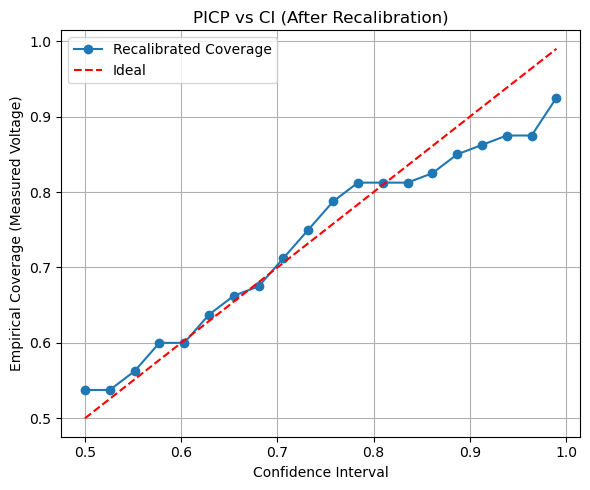

In [38]:
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import matplotlib.pyplot as plt

# Function to find optimal variance scale for Measured Voltage (target index 0)
def find_optimal_variance_scale_marginal(y_true, pred_mean, original_var, target_idx=0, levels=np.linspace(0.5, 0.99, 20)):
    def calibration_error(scale):
        scaled_var = original_var[:, target_idx] * scale
        errors = []
        for alpha in levels:
            z = norm.ppf((1 + alpha) / 2)
            lower = pred_mean[:, target_idx] - z * np.sqrt(scaled_var)
            upper = pred_mean[:, target_idx] + z * np.sqrt(scaled_var)
            coverage = np.mean((y_true[:, target_idx] >= lower) & (y_true[:, target_idx] <= upper))
            errors.append((coverage - alpha) ** 2)
        return np.mean(errors)

    res = minimize_scalar(calibration_error, bounds=(0.01, 5.0), method='bounded')
    return res.x

# Find the optimal scaling factor
scale_mv = find_optimal_variance_scale_marginal(y_test_np, pred_mean, total_diag, target_idx=0)

# Apply recalibration
scaled_diag = total_diag.copy()
scaled_diag[:, 0] *= scale_mv

# Plot recalibrated PICP for Measured Voltage
def plot_recalibrated_picp(y_true, pred_mean, total_var, target_idx=0, levels=np.linspace(0.5, 0.99, 20)):
    z_values = norm.ppf((1 + levels) / 2)
    coverages = []
    for z in z_values:
        lower = pred_mean[:, target_idx] - z * np.sqrt(total_var[:, target_idx])
        upper = pred_mean[:, target_idx] + z * np.sqrt(total_var[:, target_idx])
        coverage = np.mean((y_true[:, target_idx] >= lower) & (y_true[:, target_idx] <= upper))
        coverages.append(coverage)

    plt.figure(figsize=(6, 5))
    plt.plot(levels, coverages, marker='o', label='Recalibrated Coverage')
    plt.plot(levels, levels, 'r--', label='Ideal')
    plt.xlabel("Confidence Interval")
    plt.ylabel("Empirical Coverage (Measured Voltage)")
    plt.title("PICP vs CI (After Recalibration)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_recalibrated_picp(y_test_np, pred_mean, scaled_diag, target_idx=0)


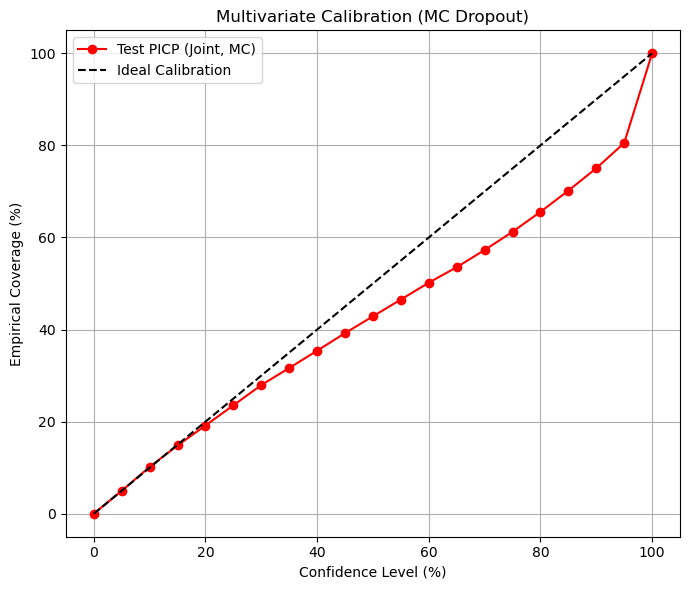

In [40]:
from scipy.stats import chi2
import numpy as np

def compute_multivariate_picp_mc_vectorized(y_true, mc_means, mc_covs, confidence_levels, eps=1e-5):
    M, N, D = mc_means.shape
    y_true = y_true[None, :, :]                   # Shape: (1, N, D)
    diff = y_true - mc_means                      # Shape: (M, N, D)

    eye = np.eye(D)[None, None, :, :]
    covs_stable = mc_covs + eps * eye
    covs_inv = np.linalg.inv(covs_stable)

    d2 = np.einsum('mnd,mndk,mnk->mn', diff, covs_inv, diff)  # Mahalanobis squared

    picps = []
    for cl in confidence_levels:
        if cl == 1.0:
            picps.append(100.0)
            continue
        chi2_thresh = chi2.ppf(cl, df=D)
        inside = d2 <= chi2_thresh
        coverage = inside.mean(axis=0).mean() * 100
        picps.append(coverage)

    return picps

import matplotlib.pyplot as plt

def plot_multivariate_picp(conf_levels, picps, label="Test", color='red'):
    plt.figure(figsize=(7, 6))
    plt.plot(conf_levels * 100, picps, marker='o', linestyle='-', color=color, label=f'{label} PICP (Joint, MC)')
    plt.plot([0, 100], [0, 100], '--', color='black', label='Ideal Calibration')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Empirical Coverage (%)')
    plt.title('Multivariate Calibration (MC Dropout)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

confidence_levels = np.linspace(0.0, 1.0, 21)
test_picp_vec = compute_multivariate_picp_mc_vectorized(y_test_np, mc_means, mc_covs, confidence_levels)
plot_multivariate_picp(confidence_levels, test_picp_vec, label="Test")


Optimal covariance scale for calibration: 1.188


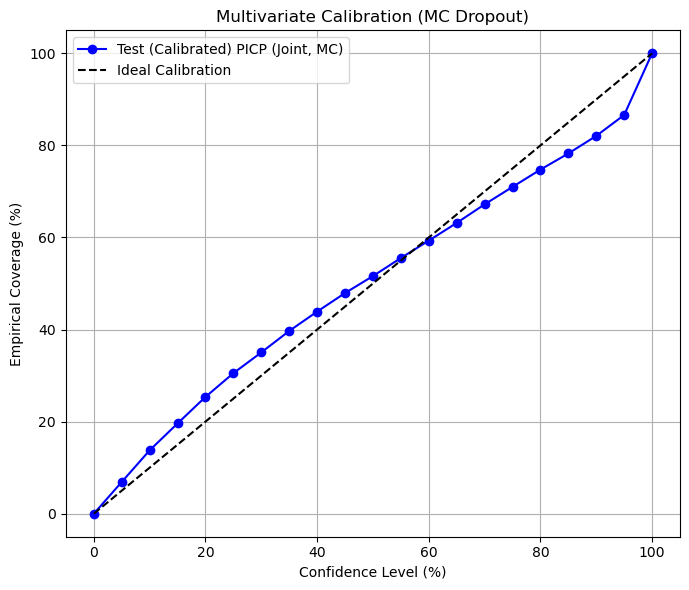

In [41]:
from scipy.optimize import minimize_scalar

def calibrate_multivariate_covariance_scale(y_true, mc_means, mc_covs, confidence_levels):
    """
    Calibrates a single scalar multiplier to apply to all MC covariance matrices,
    minimizing the squared error between empirical and nominal joint coverage.
    """
    def objective(scale):
        scaled_covs = mc_covs * (scale ** 2)
        picp_vec = compute_multivariate_picp_mc_vectorized(y_true, mc_means, scaled_covs, confidence_levels)
        return np.mean((np.array(picp_vec)/100 - confidence_levels) ** 2)

    result = minimize_scalar(objective, bounds=(0.1, 10.0), method='bounded')
    return result.x

# 🔁 Step 1: Find optimal scale
scale_opt = calibrate_multivariate_covariance_scale(
    y_true=y_test_np,
    mc_means=mc_means,
    mc_covs=mc_covs,
    confidence_levels=confidence_levels
)
print(f"Optimal covariance scale for calibration: {scale_opt:.3f}")

# 🔁 Step 2: Recalculate with scaled covariance
mc_covs_scaled = mc_covs * (scale_opt ** 2)

# 🔁 Step 3: Recompute calibrated PICP
calibrated_picp_vec = compute_multivariate_picp_mc_vectorized(
    y_test_np, mc_means, mc_covs_scaled, confidence_levels
)

# 🔁 Step 4: Plot
plot_multivariate_picp(confidence_levels, calibrated_picp_vec, label="Test (Calibrated)", color='blue')



In [42]:
def predictive_log_likelihood(y_true, mc_samples, tau):
    """
    Compute Monte Carlo estimate of predictive log-likelihood.
    
    y_true: (N, D) - ground truth targets
    mc_samples: (T, N, D) - T stochastic forward pass predictions
    tau: float - model precision (scalar)
    """
    T, N, D = mc_samples.shape
    errors = mc_samples - y_true[None, :, :]  # (T, N, D)
    sq_errors = np.sum(errors**2, axis=-1)  # (T, N)

    log_likelihoods = -0.5 * tau * sq_errors  # (T, N)
    logsumexp = np.log(np.sum(np.exp(log_likelihoods), axis=0))  # (N,)
    
    const = -np.log(T) - 0.5 * D * np.log(2 * np.pi) - 0.5 * D * np.log(1 / tau)
    predictive_ll = const + logsumexp  # (N,)

    return predictive_ll.mean()

pll = predictive_log_likelihood(y_true=y_test_np, mc_samples=mc_means, tau=tau)
print(f"Predictive Log-Likelihood (Test): {pll:.4f}")


Predictive Log-Likelihood (Test): -5.9117


In [43]:
from scipy.stats import multivariate_normal

def predictive_log_likelihood_scaled(y_true, mc_means, mc_covs_scaled):
    """
    Compute MC-estimate of log-likelihood using scaled covariances.
    y_true: shape (N, D)
    mc_means: shape (T, N, D)
    mc_covs_scaled: shape (T, N, D, D)
    """
    T, N, D = mc_means.shape
    pll = 0.0

    for i in range(N):
        logps = []
        for t in range(T):
            try:
                logp = multivariate_normal.logpdf(
                    x=y_true[i],
                    mean=mc_means[t, i],
                    cov=mc_covs_scaled[t, i]
                )
                logps.append(logp)
            except np.linalg.LinAlgError:
                continue  # skip singular covariance matrices

        # Use log-sum-exp for numerical stability
        logps = np.array(logps)
        m = np.max(logps)
        pll += m + np.log(np.mean(np.exp(logps - m)))

    return pll / N  # average over samples

pll_calibrated = predictive_log_likelihood_scaled(y_test_np, mc_means, mc_covs_scaled)
print(f"Predictive Log-Likelihood (Calibrated): {pll_calibrated:.4f}")



Predictive Log-Likelihood (Calibrated): -0.6618


In [48]:
measured_var_diag = total_diag[:, 0]
predicted_var_diag = total_diag[:, 1]

print("Avg predicted variance (Measured Voltage):", measured_var_diag.mean())
print("Avg predicted variance (Predicted Voltage):", predicted_var_diag.mean())


Avg predicted variance (Measured Voltage): 0.10269713281777997
Avg predicted variance (Predicted Voltage): 0.3110513316107293
